## What's the most popular programming language in 2020?
In this project I was interested in looking at the state of programming languages in 2020. In particular answering these questions:
- Which is the most frequently used programming language?
- Does language popularity affect salary?
- Does language popularity affect work satisfaction?
- Can we use simple linear regression to determine a developer's salary based only on the languages they use?

To answer these question I will use the Stack Overflow developer survey 2020. The results of which can be found [here](https://insights.stackoverflow.com/survey).

In this notebook I will start with the first question: Which is the most frequently used programming language.

First, let's load the data and check what questions of the survey could be related to the trends of programming languages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Start by loading the data and looking at the number of columns and rows
df = pd.read_csv('data/2020.csv')
print('Rows x Columns: ', df.shape)
print('Columns: ', list(df.columns))

Rows x Columns:  (64461, 61)
Columns:  ['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq', 'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc', 'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors', 'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith', 'MiscTechDesireNextYear', 'MiscTechWorkedWith', 'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps', 'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch', 'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms', 'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites', 'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear', 'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount', 'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength', 'Trans', 'UndergradMajor', 'WebframeDesireNextYear', 'WebframeWorkedWith', 'WelcomeChange', 'WorkWeekHrs', 'Years

The data has nearly 65 thousand rows (responses) and 61 columns (questions). To select the columns that interest us we need to better understand what each column stands for. The column names are somewhat cryptic so let's write a function which can better explain what each column stands for. To do so we can use the schema.csv.

In [2]:
schema = pd.read_csv('data/2020-schema.csv')
def explainColumn(column: str, schema: pd.DataFrame = schema) -> str:
    """
    INPUT:
    column - column name to look up information for
    schema - the dataframe, which holds information for the columns

    OUTPUT:
    Explanation for the column or the Question that this column represents from the survey
    """
    return schema.loc[schema['Column'] == column].iloc[0]['QuestionText']

# Let's look at some potentially interesting columns
print('LanguageWorkedWith: ', explainColumn('LanguageWorkedWith'))
print('LanguageDesireNextYear: ', explainColumn('LanguageDesireNextYear'))
print('JobSat: ', explainColumn('JobSat'))

LanguageWorkedWith:  Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)
LanguageDesireNextYear:  Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)
JobSat:  How satisfied are you with your current job? (If you work multiple jobs, answer for the one you spend the most hours on.)


LanguageWorkedWith seems like the most relevant column. LanguageDesireNextYear could tell us something more about the trends of programming languages, but it's not quite what we are looking for right now.

In [3]:
# Let's filter only the columns we are interested in

languages = df['LanguageWorkedWith']
languages.value_counts()

HTML/CSS;JavaScript;PHP;SQL                       1073
HTML/CSS;JavaScript                                900
C#;HTML/CSS;JavaScript;SQL                         856
C#;HTML/CSS;JavaScript;SQL;TypeScript              754
HTML/CSS;JavaScript;TypeScript                     697
                                                  ... 
C#;C++;Dart;Java;JavaScript;Python                   1
C#;Go;HTML/CSS;Java;JavaScript;Perl;Python;SQL       1
C#;Java;Julia;Python;SQL;VBA                         1
Assembly;C;Go;Java;Python;R                          1
Go;HTML/CSS;JavaScript;Python;Scala;SQL              1
Name: LanguageWorkedWith, Length: 14256, dtype: int64

By the looks of it all the languages a user has selected are in one column, separated by a semicolon. This gives us information about the whole stack of languages every developer has used during the past year, but we are really interested in the statistics for each language by itself.

Before we further process the data let's drop the NaNs, because we are only interested in the valid answers. We are not building a model to predict salary so we will not be imputing the values.


In [4]:
# Let's write a function to count all separate occurrences of programming languages 
def split_count(responses: pd.Series, separator: str = ';') -> pd.Series:
    """
    INPUT:
    responses - pandas Series with multiple values per cell, separated by a delimiter
    separator - separator between the values in each cell
    
    OUTPUT:
    pandas Series with counts for all unique occurrences of values

    e.g.
    ['C++;PHP', 'PHP'] returns ['C++': 1, 'PHP': 2]
    """
    responses = responses.astype(str).values.tolist()
    languages = {}
    for response in responses:
        splitResponse = response.split(separator)
        for lang in splitResponse:
            if lang in languages:
                languages[lang] += 1
            else:
                languages[lang] = 1
    return pd.Series(languages)

# Clean the data by dropping invalid values
languages = languages.dropna()

# Now to find the number of occurrences of each language in the responses
language_stats = pd.DataFrame(split_count(languages))
# Give the columns more meaningful names
language_stats.columns = ['Used in projects']
language_stats.columns.name = 'Language'
# Sort the dataframe by language usage
language_stats.sort_values('Used in projects', ascending=False).head(10)

Language,Used in projects
JavaScript,38822
HTML/CSS,36181
SQL,31413
Python,25287
Java,23074
Bash/Shell/PowerShell,18980
C#,18041
PHP,15007
TypeScript,14578
C++,13707


<AxesSubplot:>

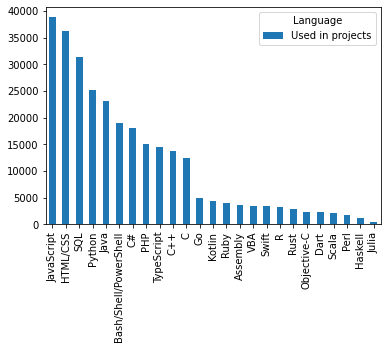

In [5]:
# Plot the language usage to better understand the data
language_stats.sort_values('Used in projects', ascending=False).plot(kind='bar')

Out of the 65 thousand developers who filled out this survey, nearly 40 thousand used JavaScript to develop a project this year or over 25 thousand used Python. In this count we are disregarding the developers who did not answer this question. So let's look at this graph as percentages removing the people who didn't answer this question in the servey.

In [6]:
(language_stats.sort_values('Used in projects', ascending=False)/languages.shape[0]).head(10)

Language,Used in projects
JavaScript,0.676601
HTML/CSS,0.630573
SQL,0.547475
Python,0.440709
Java,0.402140
Bash/Shell/PowerShell,0.330789
C#,0.314424
PHP,0.261546
TypeScript,0.254070
C++,0.238889


<AxesSubplot:>

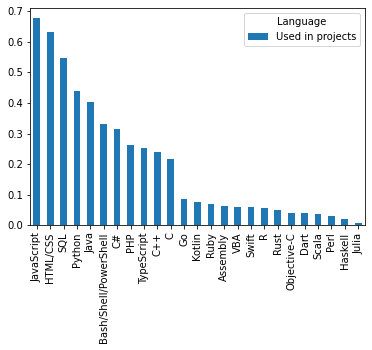

In [7]:
(language_stats.sort_values('Used in projects', ascending=False)/languages.shape[0]).plot(kind='bar')

We get the same plot, but with more meaningful numbers. Now we see that more than 65% of developers used JavaScript for one of their projects, followed closely by HTML/CSS and SQL. Only 45% used Python for a project this year. JavaScript remains the most popular language by far in the year 2020.